In [1]:
import os
import json 
import logging

logging.basicConfig(
    filename='log/app.log',            # Specify the log file name
    level=logging.DEBUG,           # Set the log level (DEBUG, INFO, WARNING, ERROR, CRITICAL)
    format='%(asctime)s - %(levelname)s - %(message)s'  # Set the log format
)

# Load the environment configuration JSON data
json_path = 'env_config.json'
with open(json_path, 'r') as file:
    env_config = json.load(file)

hf_home = env_config['HF_HOME']
# Set the HF_HOME environment variable
os.environ['HF_HOME'] = hf_home
# Set the access token to huggingface hub
access_token = env_config['access_token']
os.environ['HUGGINGFACE_HUB_TOKEN'] = access_token

In [2]:
import torch 
from transformers import ViTImageProcessor, ViTForImageClassification, ViTModel, ViTConfig
from PIL import Image
import requests
import matplotlib.pyplot as plt

import numpy as np
import cv2
from datasets import load_dataset,load_metric
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

from accelerate import Accelerator

import logging
import sys

accelerator = Accelerator()
device = accelerator.device
# device = 'cuda:3'

/opt/crc/c/conda/23.5.2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from transformers.models.vit.modeling_vit import *

class ModViTForImageClassification(ViTPreTrainedModel):
    def __init__(self, config: ViTConfig) -> None:
        super().__init__(config)

        self.num_labels = config.num_labels
        self.vit = ViTModel(config, add_pooling_layer=False, use_mask_token=True)

        # Classifier head
        self.classifier = nn.Linear(config.hidden_size, config.num_labels) if config.num_labels > 0 else nn.Identity()

        # Initialize weights and apply final processing
        self.post_init()

    def forward(
        self,
        pixel_values: Optional[torch.Tensor] = None,
        bool_masked_pos = None,
        head_mask: Optional[torch.Tensor] = None,
        labels: Optional[torch.Tensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        interpolate_pos_encoding: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[tuple, ImageClassifierOutput]:
        r"""
        labels (`torch.LongTensor` of shape `(batch_size,)`, *optional*):
            Labels for computing the image classification/regression loss. Indices should be in `[0, ...,
            config.num_labels - 1]`. If `config.num_labels == 1` a regression loss is computed (Mean-Square loss), If
            `config.num_labels > 1` a classification loss is computed (Cross-Entropy).
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.vit(
            pixel_values,
            bool_masked_pos=bool_masked_pos,
            head_mask=head_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            interpolate_pos_encoding=interpolate_pos_encoding,
            return_dict=return_dict,
        )

        sequence_output = outputs[0]

        logits = self.classifier(sequence_output[:, 0, :])

        loss = None
        if labels is not None:
            # move labels to correct device to enable model parallelism
            labels = labels.to(logits.device)
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                if self.num_labels == 1:
                    loss = loss_fct(logits.squeeze(), labels.squeeze())
                else:
                    loss = loss_fct(logits, labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)

        if not return_dict:
            output = (logits,) + outputs[1:]
            return ((loss,) + output) if loss is not None else output

        return ImageClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [4]:
# url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
# url = "http://farm3.staticflickr.com/2066/1798910782_5536af8767_z.jpg"
# url = "http://farm1.staticflickr.com/184/399924547_98e6cef97a_z.jpg"
url = "http://farm1.staticflickr.com/128/318959350_1a39aae18c_z.jpg"
image = Image.open(requests.get(url, stream=True).raw)

pretrained_name = 'google/vit-base-patch16-224'
# pretrained_name = 'vit-base-patch16-224-finetuned-imageneteval'
# pretrained_name = 'openai/clip-vit-base-patch32'
config = ViTConfig.from_pretrained(pretrained_name)
processor = ViTImageProcessor.from_pretrained(pretrained_name)
# get mean and std to unnormalize the processed images
mean, std = processor.image_mean, processor.image_std

original_model = ViTForImageClassification.from_pretrained(pretrained_name)
state_dict = original_model.state_dict()
del original_model # remove the model to free up memory
# change to use_mask_token = True
pred_model = ModViTForImageClassification(config)
# load back the parameters from state_dict
# 为新的模型实例添加 mask_token 权重
if 'vit.embeddings.mask_token' not in state_dict:
    state_dict['vit.embeddings.mask_token'] = pred_model.vit.embeddings.mask_token

pred_model.load_state_dict(state_dict)

pred_model.to(device)
# set to eval mode
pred_model.eval()
print()

/afs/crc.nd.edu/user/d/dpan/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


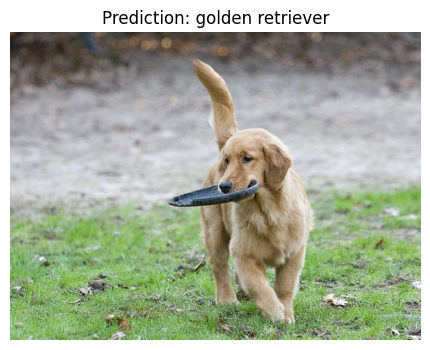

In [5]:
with torch.no_grad():
    inputs = processor(images=image, return_tensors="pt")
    inputs.to(device)
    outputs = pred_model(**inputs, output_hidden_states=True)
    logits = outputs.logits
    # model predicts one of the 1000 ImageNet classes
    predicted_class_idx = logits.argmax(-1).item()
    predicted_class = pred_model.config.id2label[predicted_class_idx]

plt.figure(figsize=(6, 4))  # 设置图像显示的大小
plt.imshow(image)
plt.axis('off')
plt.title(f'Prediction: {predicted_class}')
plt.show()

# 创建peft model 

In [6]:
from peft import LoraConfig, get_peft_model
# We use the same foundation model
exp_base_model = ViTModel.from_pretrained(pretrained_name)

# convert to peft model and ready to use LoRA 
# 手动列出所有层的目标模块

target_modules = []
num_layers = 12  # BERT-base 有 12 层
for i in range(num_layers):
    target_modules.extend([
        f"encoder.layer.{i}.attention.attention.query",
        f"encoder.layer.{i}.attention.attention.key",
        f"encoder.layer.{i}.attention.attention.value",
        f"encoder.layer.{i}.attention.output.dense",
        f"encoder.layer.{i}.intermediate.dense",
        f"encoder.layer.{i}.output.dense"
    ])

lora_config = LoraConfig(
    r=4,  # 低秩矩阵的秩
    lora_alpha=32,  # LoRA 的缩放因子
    target_modules= target_modules,  # 目标模块
    lora_dropout=0.1  # Dropout 概率
)
exp_base_model = get_peft_model(exp_base_model, lora_config)

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
from maskgen.vision_models.vision_maskgen_lora import MaskGeneratingModel

mask_gen_model = MaskGeneratingModel(base_model=exp_base_model, hidden_size=config.hidden_size, num_classes=config.num_labels)
mask_gen_model.to(device)
print()

In [8]:
from torch.utils.data import DataLoader
def load_data(seed=42): 
    dataset = load_dataset("mrm8488/ImageNet1K-val")
    dataset = dataset['train']
    splits = dataset.train_test_split(test_size=0.1, seed=seed)
    test_ds = splits['test']
    splits = splits['train'].train_test_split(test_size=0.1, seed=seed)
    train_ds = splits['train']
    val_ds = splits['test']
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = load_data()
dataset = load_dataset("mrm8488/ImageNet1K-val")['train']

normalize = Normalize(mean=processor.image_mean, std=processor.image_std)
if "height" in processor.size:
    size = (processor.size["height"], processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in processor.size:
    size = processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = processor.size.get("longest_edge")

transforms = Compose(
        [
            RandomResizedCrop(crop_size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

def preprocess(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_ds.set_transform(preprocess)
test_ds.set_transform(preprocess)
dataset.set_transform(preprocess)


batch_size = 256
# train_dataloader = DataLoader(train_ds, batch_size=batch_size, collate_fn=collate_fn, shuffle=True, num_workers=num_workers)
# train_dataloader = DataLoader(test_ds, batch_size=batch_size, collate_fn=collate_fn, shuffle=True, num_workers=num_workers)
train_dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)

Repo card metadata block was not found. Setting CardData to empty.
Repo card metadata block was not found. Setting CardData to empty.


In [17]:
from tqdm import tqdm

optimizer = torch.optim.Adam(mask_gen_model.parameters(), lr=1e-3, weight_decay=1e-5)

for epoch in range(10):
    pbar = tqdm(train_dataloader)
    for idx, data in enumerate(pbar):
        pixel_values = data['pixel_values'].to(device)
        # sim = mask_gen_model.forward(model=pred_model, pixel_values=pixel_values)
        # mask, masked_pred_logits = mask_gen_model.sample_one_step(model=pred_model, pixel_values=pixel_values, sim=sim)
        # pred_logits = mask_gen_model.get_pred_logits(model=pred_model, pixel_values=pixel_values)
        # loss_dict = mask_gen_model.loss_func(sim=sim, mask=mask, masked_pred_logits=masked_pred_logits, pred_logits=pred_logits)
        loss_dict = mask_gen_model.loss_func_v2(model=pred_model, pixel_values=pixel_values, num_samples=1)
        loss = loss_dict['loss']

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pbar.set_description(f"Epoch {epoch+1}, Step {idx+1}: Loss = {loss_dict['loss'].item():.4f}, " 
                             f"Reward Loss = {loss_dict['reward_loss'].item():.4f}, "
                             f"reward = {loss_dict['reward'].item():.4f}, "
                             f"advantage = {loss_dict['advantage'].item():.4f}, "
                             f"Mask Loss = {loss_dict['mask_loss'].item():.4f} "
                            #  f"mask_mean = {loss_dict['mask_mean'].item():.4f} "
                             f"prob_mean = {loss_dict['prob_mean'].item():.4f} "
                             )
        if idx % 10 == 0:
            print()



Epoch 1, Step 1: Loss = 0.0442, Reward Loss = 0.0424, reward = 0.1813, advantage = 0.0813, Mask Loss = 0.0185 prob_mean = 0.2542 :   1%|          | 1/196 [00:02<06:54,  2.13s/it]

Epoch 1, Step 11: Loss = 0.0359, Reward Loss = 0.0344, reward = 0.1665, advantage = 0.0665, Mask Loss = 0.0154 prob_mean = 0.2524 :   6%|▌         | 11/196 [00:22<06:18,  2.05s/it]

Epoch 1, Step 21: Loss = 0.0520, Reward Loss = 0.0497, reward = 0.1947, advantage = 0.0947, Mask Loss = 0.0229 prob_mean = 0.2562 :  11%|█         | 21/196 [00:43<06:01,  2.07s/it]

Epoch 1, Step 31: Loss = 0.0458, Reward Loss = 0.0438, reward = 0.1843, advantage = 0.0843, Mask Loss = 0.0198 prob_mean = 0.2539 :  16%|█▌        | 31/196 [01:03<05:39,  2.06s/it]

Epoch 1, Step 41: Loss = 0.0538, Reward Loss = 0.0513, reward = 0.1963, advantage = 0.0963, Mask Loss = 0.0247 prob_mean = 0.2335 :  21%|██        | 41/196 [01:24<05:18,  2.06s/it]

Epoch 1, Step 51: Loss = 0.0484, Reward Loss = 0.0463, reward = 0.1869, advantage = 0.0869, Mask Loss = 0.0207 prob_mean = 0.2459 :  26%|██▌       | 51/196 [01:45<05:08,  2.13s/it]

Epoch 1, Step 61: Loss = 0.0547, Reward Loss = 0.0523, reward = 0.1999, advantage = 0.0999, Mask Loss = 0.0239 prob_mean = 0.2447 :  31%|███       | 61/196 [02:06<04:38,  2.06s/it]

Epoch 1, Step 71: Loss = 0.0310, Reward Loss = 0.0299, reward = 0.1608, advantage = 0.0608, Mask Loss = 0.0116 prob_mean = 0.2488 :  36%|███▌      | 71/196 [02:26<04:15,  2.04s/it]

Epoch 1, Step 81: Loss = 0.0586, Reward Loss = 0.0562, reward = 0.2061, advantage = 0.1061, Mask Loss = 0.0243 prob_mean = 0.2544 :  41%|████▏     | 81/196 [02:47<03:57,  2.06s/it]

Epoch 1, Step 91: Loss = 0.0563, Reward Loss = 0.0536, reward = 0.1977, advantage = 0.0977, Mask Loss = 0.0263 prob_mean = 0.2540 :  46%|████▋     | 91/196 [03:07<03:32,  2.02s/it]

Epoch 1, Step 101: Loss = 0.0554, Reward Loss = 0.0527, reward = 0.2009, advantage = 0.1009, Mask Loss = 0.0267 prob_mean = 0.2724 :  52%|█████▏    | 101/196 [03:28<03:17,  2.08s/it]

Epoch 1, Step 111: Loss = 0.0346, Reward Loss = 0.0330, reward = 0.1668, advantage = 0.0668, Mask Loss = 0.0157 prob_mean = 0.2354 :  57%|█████▋    | 111/196 [03:48<02:53,  2.04s/it]

Epoch 1, Step 121: Loss = 0.0328, Reward Loss = 0.0314, reward = 0.1572, advantage = 0.0572, Mask Loss = 0.0140 prob_mean = 0.2511 :  62%|██████▏   | 121/196 [04:09<02:35,  2.07s/it]

Epoch 1, Step 131: Loss = 0.0464, Reward Loss = 0.0442, reward = 0.1869, advantage = 0.0869, Mask Loss = 0.0221 prob_mean = 0.2517 :  67%|██████▋   | 131/196 [04:29<02:11,  2.03s/it]

Epoch 1, Step 141: Loss = 0.0441, Reward Loss = 0.0419, reward = 0.1787, advantage = 0.0787, Mask Loss = 0.0215 prob_mean = 0.2578 :  72%|███████▏  | 141/196 [04:50<01:51,  2.03s/it]

Epoch 1, Step 151: Loss = 0.0360, Reward Loss = 0.0344, reward = 0.1590, advantage = 0.0590, Mask Loss = 0.0167 prob_mean = 0.2362 :  77%|███████▋  | 151/196 [05:10<01:31,  2.03s/it]

Epoch 1, Step 161: Loss = 0.0466, Reward Loss = 0.0445, reward = 0.1846, advantage = 0.0846, Mask Loss = 0.0203 prob_mean = 0.2299 :  82%|████████▏ | 161/196 [05:31<01:11,  2.04s/it]

Epoch 1, Step 171: Loss = 0.0344, Reward Loss = 0.0330, reward = 0.1688, advantage = 0.0688, Mask Loss = 0.0140 prob_mean = 0.2515 :  87%|████████▋ | 171/196 [05:51<00:50,  2.03s/it]

Epoch 1, Step 181: Loss = 0.0316, Reward Loss = 0.0302, reward = 0.1592, advantage = 0.0592, Mask Loss = 0.0139 prob_mean = 0.2435 :  92%|█████████▏| 181/196 [06:12<00:30,  2.05s/it]

Epoch 1, Step 191: Loss = 0.0406, Reward Loss = 0.0389, reward = 0.1713, advantage = 0.0713, Mask Loss = 0.0170 prob_mean = 0.2493 :  97%|█████████▋| 191/196 [06:32<00:10,  2.05s/it]

Epoch 1, Step 196: Loss = 0.0627, Reward Loss = 0.0604, reward = 0.2229, advantage = 0.1229, Mask Loss = 0.0229 prob_mean = 0.2562 : 100%|██████████| 196/196 [06:41<00:00,  2.05s/it]
Epoch 2, Step 1: Loss = 0.0349, Reward Loss = 0.0335, reward = 0.1656, advantage = 0.0656, Mask Loss = 0.0146 prob_mean = 0.2440 :   1%|          | 1/196 [00:01<06:28,  1.99s/it]

Epoch 2, Step 11: Loss = 0.0470, Reward Loss = 0.0449, reward = 0.1859, advantage = 0.0859, Mask Loss = 0.0208 prob_mean = 0.2525 :   6%|▌         | 11/196 [00:22<06:19,  2.05s/it]

Epoch 2, Step 21: Loss = 0.0398, Reward Loss = 0.0380, reward = 0.1717, advantage = 0.0717, Mask Loss = 0.0178 prob_mean = 0.2465 :  11%|█         | 21/196 [00:42<05:57,  2.04s/it]

Epoch 2, Step 31: Loss = 0.0309, Reward Loss = 0.0293, reward = 0.1508, advantage = 0.0508, Mask Loss = 0.0157 prob_mean = 0.2414 :  16%|█▌        | 31/196 [01:03<05:34,  2.03s/it]

Epoch 2, Step 41: Loss = 0.0384, Reward Loss = 0.0368, reward = 0.1741, advantage = 0.0741, Mask Loss = 0.0158 prob_mean = 0.2559 :  21%|██        | 41/196 [01:23<05:18,  2.06s/it]

Epoch 2, Step 51: Loss = 0.0435, Reward Loss = 0.0415, reward = 0.1767, advantage = 0.0767, Mask Loss = 0.0200 prob_mean = 0.2518 :  26%|██▌       | 51/196 [01:44<04:58,  2.06s/it]

Epoch 2, Step 61: Loss = 0.0449, Reward Loss = 0.0428, reward = 0.1792, advantage = 0.0792, Mask Loss = 0.0206 prob_mean = 0.2388 :  31%|███       | 61/196 [02:04<04:37,  2.06s/it]

Epoch 2, Step 71: Loss = 0.0447, Reward Loss = 0.0427, reward = 0.1836, advantage = 0.0836, Mask Loss = 0.0198 prob_mean = 0.2408 :  36%|███▌      | 71/196 [02:25<04:18,  2.07s/it]

Epoch 2, Step 81: Loss = 0.0475, Reward Loss = 0.0453, reward = 0.1833, advantage = 0.0833, Mask Loss = 0.0223 prob_mean = 0.2468 :  41%|████▏     | 81/196 [02:45<03:54,  2.04s/it]

Epoch 2, Step 91: Loss = 0.0326, Reward Loss = 0.0313, reward = 0.1581, advantage = 0.0581, Mask Loss = 0.0138 prob_mean = 0.2422 :  46%|████▋     | 91/196 [03:06<03:35,  2.06s/it]

Epoch 2, Step 101: Loss = 0.0441, Reward Loss = 0.0421, reward = 0.1814, advantage = 0.0814, Mask Loss = 0.0194 prob_mean = 0.2493 :  52%|█████▏    | 101/196 [03:26<03:14,  2.05s/it]

Epoch 2, Step 111: Loss = 0.0306, Reward Loss = 0.0291, reward = 0.1516, advantage = 0.0516, Mask Loss = 0.0148 prob_mean = 0.2278 :  57%|█████▋    | 111/196 [03:46<02:52,  2.03s/it]

Epoch 2, Step 121: Loss = 0.0410, Reward Loss = 0.0393, reward = 0.1759, advantage = 0.0759, Mask Loss = 0.0175 prob_mean = 0.2382 :  62%|██████▏   | 121/196 [04:07<02:32,  2.03s/it]

Epoch 2, Step 131: Loss = 0.0698, Reward Loss = 0.0667, reward = 0.2321, advantage = 0.1321, Mask Loss = 0.0314 prob_mean = 0.2639 :  67%|██████▋   | 131/196 [04:27<02:12,  2.03s/it]

Epoch 2, Step 141: Loss = 0.0467, Reward Loss = 0.0446, reward = 0.1913, advantage = 0.0913, Mask Loss = 0.0206 prob_mean = 0.2499 :  72%|███████▏  | 141/196 [04:48<01:54,  2.08s/it]

Epoch 2, Step 151: Loss = 0.0260, Reward Loss = 0.0248, reward = 0.1485, advantage = 0.0485, Mask Loss = 0.0113 prob_mean = 0.2414 :  77%|███████▋  | 151/196 [05:09<01:31,  2.03s/it]

Epoch 2, Step 161: Loss = 0.0474, Reward Loss = 0.0454, reward = 0.1921, advantage = 0.0921, Mask Loss = 0.0198 prob_mean = 0.2392 :  82%|████████▏ | 161/196 [05:29<01:11,  2.05s/it]

Epoch 2, Step 171: Loss = 0.0446, Reward Loss = 0.0427, reward = 0.1844, advantage = 0.0844, Mask Loss = 0.0199 prob_mean = 0.2337 :  87%|████████▋ | 171/196 [05:50<00:50,  2.03s/it]

Epoch 2, Step 181: Loss = 0.0353, Reward Loss = 0.0337, reward = 0.1663, advantage = 0.0663, Mask Loss = 0.0163 prob_mean = 0.2503 :  92%|█████████▏| 181/196 [06:11<00:30,  2.04s/it]

Epoch 2, Step 191: Loss = 0.0458, Reward Loss = 0.0438, reward = 0.1806, advantage = 0.0806, Mask Loss = 0.0202 prob_mean = 0.2366 :  97%|█████████▋| 191/196 [06:31<00:10,  2.08s/it]

Epoch 2, Step 196: Loss = 0.0666, Reward Loss = 0.0636, reward = 0.2261, advantage = 0.1261, Mask Loss = 0.0308 prob_mean = 0.2331 : 100%|██████████| 196/196 [06:40<00:00,  2.04s/it]
Epoch 3, Step 1: Loss = 0.0295, Reward Loss = 0.0283, reward = 0.1544, advantage = 0.0544, Mask Loss = 0.0125 prob_mean = 0.2401 :   1%|          | 1/196 [00:02<07:05,  2.18s/it]

Epoch 3, Step 11: Loss = 0.0357, Reward Loss = 0.0340, reward = 0.1650, advantage = 0.0650, Mask Loss = 0.0174 prob_mean = 0.2413 :   6%|▌         | 11/196 [00:22<06:20,  2.06s/it]

Epoch 3, Step 21: Loss = 0.0408, Reward Loss = 0.0392, reward = 0.1787, advantage = 0.0787, Mask Loss = 0.0163 prob_mean = 0.2253 :  11%|█         | 21/196 [00:43<06:06,  2.09s/it]

Epoch 3, Step 31: Loss = 0.0438, Reward Loss = 0.0420, reward = 0.1881, advantage = 0.0881, Mask Loss = 0.0177 prob_mean = 0.2442 :  16%|█▌        | 31/196 [01:04<05:42,  2.08s/it]

Epoch 3, Step 41: Loss = 0.0392, Reward Loss = 0.0376, reward = 0.1805, advantage = 0.0805, Mask Loss = 0.0158 prob_mean = 0.2350 :  21%|██        | 41/196 [01:24<05:18,  2.06s/it]

Epoch 3, Step 51: Loss = 0.0341, Reward Loss = 0.0326, reward = 0.1647, advantage = 0.0647, Mask Loss = 0.0144 prob_mean = 0.2182 :  26%|██▌       | 51/196 [01:45<05:00,  2.07s/it]

Epoch 3, Step 61: Loss = 0.0353, Reward Loss = 0.0338, reward = 0.1676, advantage = 0.0676, Mask Loss = 0.0158 prob_mean = 0.2491 :  31%|███       | 61/196 [02:05<04:37,  2.06s/it]

Epoch 3, Step 71: Loss = 0.0404, Reward Loss = 0.0386, reward = 0.1798, advantage = 0.0798, Mask Loss = 0.0178 prob_mean = 0.2471 :  36%|███▌      | 71/196 [02:26<04:17,  2.06s/it]

Epoch 3, Step 81: Loss = 0.0519, Reward Loss = 0.0493, reward = 0.1904, advantage = 0.0904, Mask Loss = 0.0263 prob_mean = 0.2474 :  41%|████▏     | 81/196 [02:47<04:00,  2.09s/it]

Epoch 3, Step 91: Loss = 0.0455, Reward Loss = 0.0435, reward = 0.1865, advantage = 0.0865, Mask Loss = 0.0197 prob_mean = 0.2305 :  46%|████▋     | 91/196 [03:07<03:37,  2.07s/it]

Epoch 3, Step 101: Loss = 0.0494, Reward Loss = 0.0469, reward = 0.1956, advantage = 0.0956, Mask Loss = 0.0254 prob_mean = 0.2483 :  52%|█████▏    | 101/196 [03:28<03:15,  2.06s/it]

Epoch 3, Step 111: Loss = 0.0522, Reward Loss = 0.0499, reward = 0.1949, advantage = 0.0949, Mask Loss = 0.0235 prob_mean = 0.2305 :  57%|█████▋    | 111/196 [03:48<02:53,  2.05s/it]

Epoch 3, Step 121: Loss = 0.0280, Reward Loss = 0.0267, reward = 0.1506, advantage = 0.0506, Mask Loss = 0.0125 prob_mean = 0.2310 :  62%|██████▏   | 121/196 [04:09<02:34,  2.07s/it]

Epoch 3, Step 131: Loss = 0.0283, Reward Loss = 0.0271, reward = 0.1487, advantage = 0.0487, Mask Loss = 0.0122 prob_mean = 0.2095 :  67%|██████▋   | 131/196 [04:29<02:14,  2.07s/it]

Epoch 3, Step 141: Loss = 0.0304, Reward Loss = 0.0290, reward = 0.1577, advantage = 0.0577, Mask Loss = 0.0136 prob_mean = 0.2328 :  72%|███████▏  | 141/196 [04:50<01:53,  2.07s/it] 

Epoch 3, Step 151: Loss = 0.0378, Reward Loss = 0.0361, reward = 0.1734, advantage = 0.0734, Mask Loss = 0.0175 prob_mean = 0.2410 :  77%|███████▋  | 151/196 [05:11<01:32,  2.07s/it]

Epoch 3, Step 161: Loss = 0.0351, Reward Loss = 0.0336, reward = 0.1623, advantage = 0.0623, Mask Loss = 0.0150 prob_mean = 0.2413 :  82%|████████▏ | 161/196 [05:31<01:12,  2.07s/it]

Epoch 3, Step 171: Loss = 0.0435, Reward Loss = 0.0413, reward = 0.1815, advantage = 0.0815, Mask Loss = 0.0218 prob_mean = 0.2341 :  87%|████████▋ | 171/196 [05:52<00:51,  2.05s/it]

Epoch 3, Step 181: Loss = 0.0349, Reward Loss = 0.0335, reward = 0.1653, advantage = 0.0653, Mask Loss = 0.0142 prob_mean = 0.2316 :  92%|█████████▏| 181/196 [06:13<00:30,  2.06s/it]

Epoch 3, Step 191: Loss = 0.0401, Reward Loss = 0.0384, reward = 0.1823, advantage = 0.0823, Mask Loss = 0.0172 prob_mean = 0.2165 :  97%|█████████▋| 191/196 [06:33<00:10,  2.06s/it]

Epoch 3, Step 196: Loss = 0.0465, Reward Loss = 0.0443, reward = 0.1812, advantage = 0.0812, Mask Loss = 0.0227 prob_mean = 0.2149 : 100%|██████████| 196/196 [06:42<00:00,  2.05s/it]
Epoch 4, Step 1: Loss = 0.0238, Reward Loss = 0.0226, reward = 0.1429, advantage = 0.0429, Mask Loss = 0.0120 prob_mean = 0.2184 :   1%|          | 1/196 [00:02<07:01,  2.16s/it]

Epoch 4, Step 11: Loss = 0.0365, Reward Loss = 0.0350, reward = 0.1721, advantage = 0.0721, Mask Loss = 0.0148 prob_mean = 0.2315 :   6%|▌         | 11/196 [00:22<06:28,  2.10s/it]

Epoch 4, Step 21: Loss = 0.0415, Reward Loss = 0.0398, reward = 0.1820, advantage = 0.0820, Mask Loss = 0.0169 prob_mean = 0.2393 :  11%|█         | 21/196 [00:43<06:00,  2.06s/it]

Epoch 4, Step 31: Loss = 0.0445, Reward Loss = 0.0423, reward = 0.1795, advantage = 0.0795, Mask Loss = 0.0213 prob_mean = 0.2324 :  16%|█▌        | 31/196 [01:04<05:40,  2.06s/it]

Epoch 4, Step 41: Loss = 0.0364, Reward Loss = 0.0349, reward = 0.1739, advantage = 0.0739, Mask Loss = 0.0151 prob_mean = 0.2151 :  21%|██        | 41/196 [01:24<05:19,  2.06s/it]

Epoch 4, Step 51: Loss = 0.0155, Reward Loss = 0.0149, reward = 0.1306, advantage = 0.0306, Mask Loss = 0.0055 prob_mean = 0.2262 :  26%|██▌       | 51/196 [01:45<04:55,  2.04s/it]

Epoch 4, Step 61: Loss = 0.0396, Reward Loss = 0.0377, reward = 0.1721, advantage = 0.0721, Mask Loss = 0.0188 prob_mean = 0.2268 :  31%|███       | 61/196 [02:05<04:36,  2.05s/it]

Epoch 4, Step 71: Loss = 0.0406, Reward Loss = 0.0390, reward = 0.1890, advantage = 0.0890, Mask Loss = 0.0166 prob_mean = 0.2459 :  36%|███▌      | 71/196 [02:26<04:14,  2.04s/it]

Epoch 4, Step 81: Loss = 0.0507, Reward Loss = 0.0485, reward = 0.1943, advantage = 0.0943, Mask Loss = 0.0222 prob_mean = 0.2379 :  41%|████▏     | 81/196 [02:47<03:56,  2.06s/it]

Epoch 4, Step 91: Loss = 0.0711, Reward Loss = 0.0678, reward = 0.2317, advantage = 0.1317, Mask Loss = 0.0329 prob_mean = 0.2387 :  46%|████▋     | 91/196 [03:07<03:36,  2.06s/it]

Epoch 4, Step 101: Loss = 0.0439, Reward Loss = 0.0418, reward = 0.1797, advantage = 0.0797, Mask Loss = 0.0210 prob_mean = 0.2316 :  52%|█████▏    | 101/196 [03:28<03:13,  2.04s/it]

Epoch 4, Step 111: Loss = 0.0600, Reward Loss = 0.0572, reward = 0.2073, advantage = 0.1073, Mask Loss = 0.0286 prob_mean = 0.2409 :  57%|█████▋    | 111/196 [03:48<02:55,  2.06s/it]

Epoch 4, Step 121: Loss = 0.0404, Reward Loss = 0.0384, reward = 0.1698, advantage = 0.0698, Mask Loss = 0.0204 prob_mean = 0.2345 :  62%|██████▏   | 121/196 [04:09<02:36,  2.09s/it]

Epoch 4, Step 131: Loss = 0.0390, Reward Loss = 0.0373, reward = 0.1717, advantage = 0.0717, Mask Loss = 0.0168 prob_mean = 0.2481 :  67%|██████▋   | 131/196 [04:30<02:16,  2.10s/it]

Epoch 4, Step 141: Loss = 0.0260, Reward Loss = 0.0248, reward = 0.1436, advantage = 0.0436, Mask Loss = 0.0120 prob_mean = 0.2425 :  72%|███████▏  | 141/196 [04:50<01:52,  2.05s/it]

Epoch 4, Step 151: Loss = 0.0413, Reward Loss = 0.0391, reward = 0.1708, advantage = 0.0708, Mask Loss = 0.0217 prob_mean = 0.2530 :  77%|███████▋  | 151/196 [05:11<01:32,  2.06s/it]

Epoch 4, Step 161: Loss = 0.0546, Reward Loss = 0.0520, reward = 0.1993, advantage = 0.0993, Mask Loss = 0.0269 prob_mean = 0.2440 :  82%|████████▏ | 161/196 [05:31<01:12,  2.06s/it]

Epoch 4, Step 171: Loss = 0.0591, Reward Loss = 0.0563, reward = 0.2132, advantage = 0.1132, Mask Loss = 0.0275 prob_mean = 0.2551 :  87%|████████▋ | 171/196 [05:52<00:51,  2.06s/it]

Epoch 4, Step 181: Loss = 0.0571, Reward Loss = 0.0544, reward = 0.2085, advantage = 0.1085, Mask Loss = 0.0267 prob_mean = 0.2526 :  92%|█████████▏| 181/196 [06:12<00:30,  2.04s/it]

Epoch 4, Step 191: Loss = 0.0387, Reward Loss = 0.0370, reward = 0.1806, advantage = 0.0806, Mask Loss = 0.0170 prob_mean = 0.2321 :  97%|█████████▋| 191/196 [06:33<00:10,  2.08s/it]

Epoch 4, Step 196: Loss = 0.0345, Reward Loss = 0.0332, reward = 0.1596, advantage = 0.0596, Mask Loss = 0.0122 prob_mean = 0.2307 : 100%|██████████| 196/196 [06:42<00:00,  2.05s/it]
Epoch 5, Step 1: Loss = 0.0507, Reward Loss = 0.0483, reward = 0.1926, advantage = 0.0926, Mask Loss = 0.0236 prob_mean = 0.2317 :   1%|          | 1/196 [00:02<06:34,  2.02s/it]

Epoch 5, Step 11: Loss = 0.0467, Reward Loss = 0.0445, reward = 0.1931, advantage = 0.0931, Mask Loss = 0.0215 prob_mean = 0.2543 :   6%|▌         | 11/196 [00:22<06:32,  2.12s/it]

Epoch 5, Step 21: Loss = 0.0428, Reward Loss = 0.0407, reward = 0.1832, advantage = 0.0832, Mask Loss = 0.0211 prob_mean = 0.2415 :  11%|█         | 21/196 [00:43<05:57,  2.04s/it]

Epoch 5, Step 31: Loss = 0.0273, Reward Loss = 0.0260, reward = 0.1512, advantage = 0.0512, Mask Loss = 0.0130 prob_mean = 0.2519 :  16%|█▌        | 31/196 [01:03<05:35,  2.04s/it]

Epoch 5, Step 41: Loss = 0.0448, Reward Loss = 0.0427, reward = 0.1836, advantage = 0.0836, Mask Loss = 0.0210 prob_mean = 0.2295 :  21%|██        | 41/196 [01:24<05:18,  2.06s/it]

Epoch 5, Step 51: Loss = 0.0463, Reward Loss = 0.0441, reward = 0.1860, advantage = 0.0860, Mask Loss = 0.0213 prob_mean = 0.2261 :  26%|██▌       | 51/196 [01:45<04:59,  2.07s/it]

Epoch 5, Step 61: Loss = 0.0587, Reward Loss = 0.0556, reward = 0.2099, advantage = 0.1099, Mask Loss = 0.0306 prob_mean = 0.2501 :  31%|███       | 61/196 [02:05<04:36,  2.05s/it]

Epoch 5, Step 71: Loss = 0.0626, Reward Loss = 0.0595, reward = 0.2222, advantage = 0.1222, Mask Loss = 0.0301 prob_mean = 0.2369 :  36%|███▌      | 71/196 [02:26<04:18,  2.07s/it]

Epoch 5, Step 81: Loss = 0.0354, Reward Loss = 0.0337, reward = 0.1618, advantage = 0.0618, Mask Loss = 0.0171 prob_mean = 0.2330 :  41%|████▏     | 81/196 [02:46<03:55,  2.05s/it]

Epoch 5, Step 91: Loss = 0.0359, Reward Loss = 0.0342, reward = 0.1693, advantage = 0.0693, Mask Loss = 0.0170 prob_mean = 0.2085 :  46%|████▋     | 91/196 [03:07<03:44,  2.13s/it]

Epoch 5, Step 101: Loss = 0.0276, Reward Loss = 0.0261, reward = 0.1504, advantage = 0.0504, Mask Loss = 0.0150 prob_mean = 0.2384 :  52%|█████▏    | 101/196 [03:28<03:16,  2.07s/it]

Epoch 5, Step 111: Loss = 0.0266, Reward Loss = 0.0255, reward = 0.1531, advantage = 0.0531, Mask Loss = 0.0118 prob_mean = 0.2205 :  57%|█████▋    | 111/196 [03:49<02:56,  2.08s/it]

Epoch 5, Step 121: Loss = 0.0443, Reward Loss = 0.0424, reward = 0.1846, advantage = 0.0846, Mask Loss = 0.0189 prob_mean = 0.2349 :  62%|██████▏   | 121/196 [04:09<02:33,  2.04s/it]

Epoch 5, Step 131: Loss = 0.0417, Reward Loss = 0.0395, reward = 0.1765, advantage = 0.0765, Mask Loss = 0.0228 prob_mean = 0.2327 :  67%|██████▋   | 131/196 [04:30<02:15,  2.08s/it]

Epoch 5, Step 141: Loss = 0.0352, Reward Loss = 0.0337, reward = 0.1673, advantage = 0.0673, Mask Loss = 0.0152 prob_mean = 0.2217 :  72%|███████▏  | 141/196 [04:51<01:53,  2.07s/it]

Epoch 5, Step 151: Loss = 0.0346, Reward Loss = 0.0329, reward = 0.1646, advantage = 0.0646, Mask Loss = 0.0163 prob_mean = 0.2297 :  77%|███████▋  | 151/196 [05:11<01:32,  2.06s/it]

Epoch 5, Step 161: Loss = 0.0330, Reward Loss = 0.0315, reward = 0.1659, advantage = 0.0659, Mask Loss = 0.0150 prob_mean = 0.2276 :  82%|████████▏ | 161/196 [05:32<01:11,  2.05s/it]

Epoch 5, Step 171: Loss = 0.0461, Reward Loss = 0.0441, reward = 0.1969, advantage = 0.0969, Mask Loss = 0.0200 prob_mean = 0.2167 :  87%|████████▋ | 171/196 [05:52<00:50,  2.04s/it]

Epoch 5, Step 181: Loss = 0.0159, Reward Loss = 0.0151, reward = 0.1248, advantage = 0.0248, Mask Loss = 0.0080 prob_mean = 0.2270 :  92%|█████████▏| 181/196 [06:13<00:30,  2.05s/it]

Epoch 5, Step 191: Loss = 0.0310, Reward Loss = 0.0297, reward = 0.1603, advantage = 0.0603, Mask Loss = 0.0127 prob_mean = 0.2269 :  97%|█████████▋| 191/196 [06:33<00:10,  2.06s/it]

Epoch 5, Step 196: Loss = 0.0331, Reward Loss = 0.0312, reward = 0.1576, advantage = 0.0576, Mask Loss = 0.0191 prob_mean = 0.2466 : 100%|██████████| 196/196 [06:42<00:00,  2.05s/it]
Epoch 6, Step 1: Loss = 0.0558, Reward Loss = 0.0534, reward = 0.2153, advantage = 0.1153, Mask Loss = 0.0236 prob_mean = 0.2189 :   1%|          | 1/196 [00:02<06:32,  2.01s/it]

Epoch 6, Step 11: Loss = 0.0464, Reward Loss = 0.0444, reward = 0.1885, advantage = 0.0885, Mask Loss = 0.0198 prob_mean = 0.2228 :   6%|▌         | 11/196 [00:22<06:21,  2.06s/it]

Epoch 6, Step 21: Loss = 0.0454, Reward Loss = 0.0436, reward = 0.1888, advantage = 0.0888, Mask Loss = 0.0187 prob_mean = 0.2345 :  11%|█         | 21/196 [00:43<05:58,  2.05s/it]

Epoch 6, Step 31: Loss = 0.0359, Reward Loss = 0.0342, reward = 0.1619, advantage = 0.0619, Mask Loss = 0.0171 prob_mean = 0.2207 :  16%|█▌        | 31/196 [01:03<05:34,  2.03s/it]

Epoch 6, Step 41: Loss = 0.0438, Reward Loss = 0.0418, reward = 0.1876, advantage = 0.0876, Mask Loss = 0.0191 prob_mean = 0.2329 :  21%|██        | 41/196 [01:24<05:22,  2.08s/it]

Epoch 6, Step 51: Loss = 0.0248, Reward Loss = 0.0236, reward = 0.1494, advantage = 0.0494, Mask Loss = 0.0114 prob_mean = 0.2269 :  26%|██▌       | 51/196 [01:44<04:58,  2.06s/it]

Epoch 6, Step 61: Loss = 0.0244, Reward Loss = 0.0232, reward = 0.1478, advantage = 0.0478, Mask Loss = 0.0112 prob_mean = 0.2050 :  31%|███       | 61/196 [02:05<04:37,  2.06s/it]

Epoch 6, Step 71: Loss = 0.0250, Reward Loss = 0.0239, reward = 0.1499, advantage = 0.0499, Mask Loss = 0.0109 prob_mean = 0.2192 :  36%|███▌      | 71/196 [02:25<04:14,  2.03s/it]

Epoch 6, Step 81: Loss = 0.0327, Reward Loss = 0.0310, reward = 0.1622, advantage = 0.0622, Mask Loss = 0.0168 prob_mean = 0.2251 :  41%|████▏     | 81/196 [02:46<03:56,  2.05s/it]

Epoch 6, Step 91: Loss = 0.0612, Reward Loss = 0.0582, reward = 0.2134, advantage = 0.1134, Mask Loss = 0.0300 prob_mean = 0.2352 :  46%|████▋     | 91/196 [03:06<03:33,  2.03s/it]

Epoch 6, Step 101: Loss = 0.0249, Reward Loss = 0.0237, reward = 0.1450, advantage = 0.0450, Mask Loss = 0.0120 prob_mean = 0.2218 :  52%|█████▏    | 101/196 [03:27<03:13,  2.03s/it]

Epoch 6, Step 111: Loss = 0.0453, Reward Loss = 0.0433, reward = 0.1889, advantage = 0.0889, Mask Loss = 0.0204 prob_mean = 0.2296 :  57%|█████▋    | 111/196 [03:47<02:57,  2.09s/it]

Epoch 6, Step 121: Loss = 0.0331, Reward Loss = 0.0314, reward = 0.1606, advantage = 0.0606, Mask Loss = 0.0164 prob_mean = 0.2387 :  62%|██████▏   | 121/196 [04:08<02:38,  2.11s/it]

Epoch 6, Step 131: Loss = 0.0338, Reward Loss = 0.0323, reward = 0.1650, advantage = 0.0650, Mask Loss = 0.0154 prob_mean = 0.2216 :  67%|██████▋   | 131/196 [04:29<02:15,  2.08s/it]

Epoch 6, Step 141: Loss = 0.0470, Reward Loss = 0.0450, reward = 0.1965, advantage = 0.0965, Mask Loss = 0.0202 prob_mean = 0.2234 :  72%|███████▏  | 141/196 [04:50<01:53,  2.06s/it]

Epoch 6, Step 151: Loss = 0.0213, Reward Loss = 0.0204, reward = 0.1393, advantage = 0.0393, Mask Loss = 0.0091 prob_mean = 0.2107 :  77%|███████▋  | 151/196 [05:10<01:34,  2.09s/it]

Epoch 6, Step 161: Loss = 0.0417, Reward Loss = 0.0395, reward = 0.1743, advantage = 0.0743, Mask Loss = 0.0223 prob_mean = 0.2314 :  82%|████████▏ | 161/196 [05:31<01:12,  2.06s/it]

Epoch 6, Step 171: Loss = 0.0196, Reward Loss = 0.0187, reward = 0.1316, advantage = 0.0316, Mask Loss = 0.0088 prob_mean = 0.2215 :  87%|████████▋ | 171/196 [05:52<00:51,  2.07s/it]

Epoch 6, Step 181: Loss = 0.0453, Reward Loss = 0.0430, reward = 0.1828, advantage = 0.0828, Mask Loss = 0.0232 prob_mean = 0.2320 :  92%|█████████▏| 181/196 [06:12<00:30,  2.05s/it]

Epoch 6, Step 191: Loss = 0.0420, Reward Loss = 0.0401, reward = 0.1875, advantage = 0.0875, Mask Loss = 0.0186 prob_mean = 0.2255 :  97%|█████████▋| 191/196 [06:33<00:10,  2.09s/it]

Epoch 6, Step 196: Loss = 0.0591, Reward Loss = 0.0560, reward = 0.2062, advantage = 0.1062, Mask Loss = 0.0309 prob_mean = 0.2443 : 100%|██████████| 196/196 [06:42<00:00,  2.05s/it]
Epoch 7, Step 1: Loss = 0.0240, Reward Loss = 0.0231, reward = 0.1570, advantage = 0.0570, Mask Loss = 0.0087 prob_mean = 0.2438 :   1%|          | 1/196 [00:02<06:37,  2.04s/it]

Epoch 7, Step 11: Loss = 0.0566, Reward Loss = 0.0538, reward = 0.2033, advantage = 0.1033, Mask Loss = 0.0282 prob_mean = 0.2259 :   6%|▌         | 11/196 [00:22<06:21,  2.06s/it]

Epoch 7, Step 21: Loss = 0.0555, Reward Loss = 0.0529, reward = 0.2117, advantage = 0.1117, Mask Loss = 0.0261 prob_mean = 0.2165 :  11%|█         | 21/196 [00:43<05:59,  2.05s/it]

Epoch 7, Step 31: Loss = 0.0362, Reward Loss = 0.0345, reward = 0.1718, advantage = 0.0718, Mask Loss = 0.0166 prob_mean = 0.2082 :  16%|█▌        | 31/196 [01:04<05:43,  2.08s/it]

Epoch 7, Step 41: Loss = 0.0266, Reward Loss = 0.0253, reward = 0.1515, advantage = 0.0515, Mask Loss = 0.0136 prob_mean = 0.2067 :  21%|██        | 41/196 [01:24<05:17,  2.05s/it]

Epoch 7, Step 51: Loss = 0.0389, Reward Loss = 0.0371, reward = 0.1810, advantage = 0.0810, Mask Loss = 0.0173 prob_mean = 0.2092 :  26%|██▌       | 51/196 [01:45<04:59,  2.06s/it]

Epoch 7, Step 61: Loss = 0.0269, Reward Loss = 0.0257, reward = 0.1551, advantage = 0.0551, Mask Loss = 0.0124 prob_mean = 0.2085 :  31%|███       | 61/196 [02:05<04:38,  2.06s/it]

Epoch 7, Step 71: Loss = 0.0377, Reward Loss = 0.0361, reward = 0.1821, advantage = 0.0821, Mask Loss = 0.0163 prob_mean = 0.2107 :  36%|███▌      | 71/196 [02:26<04:20,  2.09s/it]

Epoch 7, Step 81: Loss = 0.0334, Reward Loss = 0.0317, reward = 0.1644, advantage = 0.0644, Mask Loss = 0.0172 prob_mean = 0.2351 :  41%|████▏     | 81/196 [02:47<03:56,  2.06s/it]

Epoch 7, Step 91: Loss = 0.0326, Reward Loss = 0.0310, reward = 0.1645, advantage = 0.0645, Mask Loss = 0.0160 prob_mean = 0.2215 :  46%|████▋     | 91/196 [03:07<03:33,  2.04s/it]

Epoch 7, Step 101: Loss = 0.0315, Reward Loss = 0.0300, reward = 0.1593, advantage = 0.0593, Mask Loss = 0.0147 prob_mean = 0.2309 :  52%|█████▏    | 101/196 [03:28<03:16,  2.07s/it]

Epoch 7, Step 111: Loss = 0.0300, Reward Loss = 0.0285, reward = 0.1548, advantage = 0.0548, Mask Loss = 0.0141 prob_mean = 0.2229 :  57%|█████▋    | 111/196 [03:49<02:57,  2.09s/it]

Epoch 7, Step 121: Loss = 0.0257, Reward Loss = 0.0246, reward = 0.1525, advantage = 0.0525, Mask Loss = 0.0118 prob_mean = 0.2209 :  62%|██████▏   | 121/196 [04:09<02:32,  2.03s/it]

Epoch 7, Step 131: Loss = 0.0308, Reward Loss = 0.0295, reward = 0.1613, advantage = 0.0613, Mask Loss = 0.0131 prob_mean = 0.2234 :  67%|██████▋   | 131/196 [04:29<02:12,  2.03s/it]

Epoch 7, Step 141: Loss = 0.0446, Reward Loss = 0.0425, reward = 0.1917, advantage = 0.0917, Mask Loss = 0.0216 prob_mean = 0.2198 :  72%|███████▏  | 141/196 [04:50<01:54,  2.08s/it]

Epoch 7, Step 151: Loss = 0.0267, Reward Loss = 0.0255, reward = 0.1569, advantage = 0.0569, Mask Loss = 0.0112 prob_mean = 0.2220 :  77%|███████▋  | 151/196 [05:11<01:32,  2.05s/it]

Epoch 7, Step 161: Loss = 0.0467, Reward Loss = 0.0443, reward = 0.1888, advantage = 0.0888, Mask Loss = 0.0231 prob_mean = 0.2135 :  82%|████████▏ | 161/196 [05:31<01:12,  2.07s/it]

Epoch 7, Step 171: Loss = 0.0301, Reward Loss = 0.0287, reward = 0.1607, advantage = 0.0607, Mask Loss = 0.0132 prob_mean = 0.2163 :  87%|████████▋ | 171/196 [05:52<00:51,  2.08s/it]

Epoch 7, Step 181: Loss = 0.0485, Reward Loss = 0.0461, reward = 0.1983, advantage = 0.0983, Mask Loss = 0.0231 prob_mean = 0.2266 :  92%|█████████▏| 181/196 [06:13<00:31,  2.07s/it]

Epoch 7, Step 191: Loss = 0.0337, Reward Loss = 0.0320, reward = 0.1656, advantage = 0.0656, Mask Loss = 0.0167 prob_mean = 0.2375 :  97%|█████████▋| 191/196 [06:33<00:10,  2.05s/it]

Epoch 7, Step 196: Loss = 0.0217, Reward Loss = 0.0208, reward = 0.1387, advantage = 0.0387, Mask Loss = 0.0091 prob_mean = 0.2124 : 100%|██████████| 196/196 [06:42<00:00,  2.05s/it]
Epoch 8, Step 1: Loss = 0.0516, Reward Loss = 0.0492, reward = 0.1962, advantage = 0.0962, Mask Loss = 0.0248 prob_mean = 0.2374 :   1%|          | 1/196 [00:02<06:32,  2.01s/it]

Epoch 8, Step 11: Loss = 0.0515, Reward Loss = 0.0491, reward = 0.2043, advantage = 0.1043, Mask Loss = 0.0242 prob_mean = 0.2299 :   6%|▌         | 11/196 [00:22<06:28,  2.10s/it]

Epoch 8, Step 21: Loss = 0.0357, Reward Loss = 0.0340, reward = 0.1689, advantage = 0.0689, Mask Loss = 0.0162 prob_mean = 0.2207 :  11%|█         | 21/196 [00:43<05:59,  2.05s/it]

Epoch 8, Step 31: Loss = 0.0267, Reward Loss = 0.0256, reward = 0.1573, advantage = 0.0573, Mask Loss = 0.0112 prob_mean = 0.2207 :  16%|█▌        | 31/196 [01:03<05:37,  2.05s/it]

Epoch 8, Step 41: Loss = 0.0347, Reward Loss = 0.0331, reward = 0.1619, advantage = 0.0619, Mask Loss = 0.0162 prob_mean = 0.2244 :  21%|██        | 41/196 [01:24<05:21,  2.07s/it]

Epoch 8, Step 51: Loss = 0.0399, Reward Loss = 0.0381, reward = 0.1839, advantage = 0.0839, Mask Loss = 0.0184 prob_mean = 0.2221 :  26%|██▌       | 51/196 [01:45<04:58,  2.06s/it]

Epoch 8, Step 61: Loss = 0.0470, Reward Loss = 0.0445, reward = 0.1939, advantage = 0.0939, Mask Loss = 0.0258 prob_mean = 0.2145 :  31%|███       | 61/196 [02:06<04:36,  2.05s/it]

Epoch 8, Step 71: Loss = 0.0337, Reward Loss = 0.0322, reward = 0.1655, advantage = 0.0655, Mask Loss = 0.0150 prob_mean = 0.2218 :  36%|███▌      | 71/196 [02:26<04:15,  2.04s/it]

Epoch 8, Step 81: Loss = 0.0365, Reward Loss = 0.0349, reward = 0.1785, advantage = 0.0785, Mask Loss = 0.0160 prob_mean = 0.2147 :  41%|████▏     | 81/196 [02:47<03:58,  2.08s/it]

Epoch 8, Step 91: Loss = 0.0293, Reward Loss = 0.0279, reward = 0.1576, advantage = 0.0576, Mask Loss = 0.0141 prob_mean = 0.2118 :  46%|████▋     | 91/196 [03:08<03:40,  2.10s/it]

Epoch 8, Step 101: Loss = 0.0451, Reward Loss = 0.0428, reward = 0.1896, advantage = 0.0896, Mask Loss = 0.0224 prob_mean = 0.2076 :  52%|█████▏    | 101/196 [03:28<03:14,  2.05s/it]

Epoch 8, Step 111: Loss = 0.0269, Reward Loss = 0.0255, reward = 0.1526, advantage = 0.0526, Mask Loss = 0.0144 prob_mean = 0.2170 :  57%|█████▋    | 111/196 [03:49<02:53,  2.04s/it]

Epoch 8, Step 121: Loss = 0.0448, Reward Loss = 0.0425, reward = 0.1855, advantage = 0.0855, Mask Loss = 0.0232 prob_mean = 0.2179 :  62%|██████▏   | 121/196 [04:09<02:33,  2.05s/it]

Epoch 8, Step 131: Loss = 0.0258, Reward Loss = 0.0245, reward = 0.1503, advantage = 0.0503, Mask Loss = 0.0127 prob_mean = 0.2196 :  67%|██████▋   | 131/196 [04:30<02:13,  2.05s/it]

Epoch 8, Step 141: Loss = 0.0232, Reward Loss = 0.0222, reward = 0.1360, advantage = 0.0360, Mask Loss = 0.0106 prob_mean = 0.2029 :  72%|███████▏  | 141/196 [04:50<01:52,  2.04s/it]

Epoch 8, Step 151: Loss = 0.0518, Reward Loss = 0.0492, reward = 0.1995, advantage = 0.0995, Mask Loss = 0.0258 prob_mean = 0.2167 :  77%|███████▋  | 151/196 [05:11<01:32,  2.07s/it]

Epoch 8, Step 161: Loss = 0.0422, Reward Loss = 0.0401, reward = 0.1790, advantage = 0.0790, Mask Loss = 0.0208 prob_mean = 0.2278 :  82%|████████▏ | 161/196 [05:32<01:11,  2.04s/it]

Epoch 8, Step 171: Loss = 0.0301, Reward Loss = 0.0287, reward = 0.1593, advantage = 0.0593, Mask Loss = 0.0140 prob_mean = 0.2289 :  87%|████████▋ | 171/196 [05:52<00:51,  2.07s/it]

Epoch 8, Step 181: Loss = 0.0423, Reward Loss = 0.0403, reward = 0.1898, advantage = 0.0898, Mask Loss = 0.0209 prob_mean = 0.2204 :  92%|█████████▏| 181/196 [06:13<00:31,  2.08s/it]

Epoch 8, Step 191: Loss = 0.0500, Reward Loss = 0.0473, reward = 0.1954, advantage = 0.0954, Mask Loss = 0.0267 prob_mean = 0.2138 :  97%|█████████▋| 191/196 [06:33<00:10,  2.07s/it]

Epoch 8, Step 196: Loss = 0.0412, Reward Loss = 0.0383, reward = 0.1599, advantage = 0.0599, Mask Loss = 0.0286 prob_mean = 0.2342 : 100%|██████████| 196/196 [06:42<00:00,  2.06s/it]
Epoch 9, Step 1: Loss = 0.0504, Reward Loss = 0.0480, reward = 0.2004, advantage = 0.1004, Mask Loss = 0.0242 prob_mean = 0.2186 :   1%|          | 1/196 [00:02<06:39,  2.05s/it]

Epoch 9, Step 11: Loss = 0.0272, Reward Loss = 0.0258, reward = 0.1575, advantage = 0.0575, Mask Loss = 0.0138 prob_mean = 0.1873 :   6%|▌         | 11/196 [00:22<06:18,  2.05s/it]

Epoch 9, Step 21: Loss = 0.0348, Reward Loss = 0.0332, reward = 0.1730, advantage = 0.0730, Mask Loss = 0.0160 prob_mean = 0.2004 :  11%|█         | 21/196 [00:43<06:01,  2.06s/it]

Epoch 9, Step 31: Loss = 0.0389, Reward Loss = 0.0372, reward = 0.1805, advantage = 0.0805, Mask Loss = 0.0171 prob_mean = 0.2122 :  16%|█▌        | 31/196 [01:03<05:40,  2.07s/it]

Epoch 9, Step 41: Loss = 0.0343, Reward Loss = 0.0323, reward = 0.1626, advantage = 0.0626, Mask Loss = 0.0194 prob_mean = 0.2188 :  21%|██        | 41/196 [01:24<05:19,  2.06s/it]

Epoch 9, Step 51: Loss = 0.0460, Reward Loss = 0.0437, reward = 0.1943, advantage = 0.0943, Mask Loss = 0.0233 prob_mean = 0.2250 :  26%|██▌       | 51/196 [01:45<04:54,  2.03s/it]

Epoch 9, Step 61: Loss = 0.0333, Reward Loss = 0.0318, reward = 0.1678, advantage = 0.0678, Mask Loss = 0.0155 prob_mean = 0.2123 :  31%|███       | 61/196 [02:05<04:32,  2.02s/it]

Epoch 9, Step 71: Loss = 0.0409, Reward Loss = 0.0389, reward = 0.1761, advantage = 0.0761, Mask Loss = 0.0206 prob_mean = 0.2195 :  36%|███▌      | 71/196 [02:25<04:19,  2.08s/it]

Epoch 9, Step 81: Loss = 0.0226, Reward Loss = 0.0216, reward = 0.1427, advantage = 0.0427, Mask Loss = 0.0103 prob_mean = 0.2028 :  41%|████▏     | 81/196 [02:46<03:59,  2.08s/it]

Epoch 9, Step 91: Loss = 0.0279, Reward Loss = 0.0267, reward = 0.1585, advantage = 0.0585, Mask Loss = 0.0128 prob_mean = 0.2015 :  46%|████▋     | 91/196 [03:36<14:17,  8.17s/it]

Epoch 9, Step 101: Loss = 0.0288, Reward Loss = 0.0276, reward = 0.1583, advantage = 0.0583, Mask Loss = 0.0116 prob_mean = 0.2173 :  52%|█████▏    | 101/196 [03:56<03:31,  2.23s/it]

Epoch 9, Step 111: Loss = 0.0367, Reward Loss = 0.0349, reward = 0.1694, advantage = 0.0694, Mask Loss = 0.0179 prob_mean = 0.2161 :  57%|█████▋    | 111/196 [04:17<02:59,  2.11s/it]

Epoch 9, Step 121: Loss = 0.0421, Reward Loss = 0.0401, reward = 0.1832, advantage = 0.0832, Mask Loss = 0.0196 prob_mean = 0.2172 :  62%|██████▏   | 121/196 [04:38<02:35,  2.07s/it]

Epoch 9, Step 131: Loss = 0.0434, Reward Loss = 0.0411, reward = 0.1898, advantage = 0.0898, Mask Loss = 0.0233 prob_mean = 0.2135 :  67%|██████▋   | 131/196 [04:59<02:15,  2.09s/it]

Epoch 9, Step 141: Loss = 0.0357, Reward Loss = 0.0340, reward = 0.1723, advantage = 0.0723, Mask Loss = 0.0164 prob_mean = 0.2203 :  72%|███████▏  | 141/196 [05:20<01:55,  2.09s/it]

Epoch 9, Step 151: Loss = 0.0549, Reward Loss = 0.0523, reward = 0.2146, advantage = 0.1146, Mask Loss = 0.0259 prob_mean = 0.2309 :  77%|███████▋  | 151/196 [05:40<01:33,  2.07s/it]

Epoch 9, Step 161: Loss = 0.0416, Reward Loss = 0.0395, reward = 0.1837, advantage = 0.0837, Mask Loss = 0.0215 prob_mean = 0.2086 :  82%|████████▏ | 161/196 [06:01<01:12,  2.06s/it]

Epoch 9, Step 171: Loss = 0.0497, Reward Loss = 0.0472, reward = 0.1891, advantage = 0.0891, Mask Loss = 0.0253 prob_mean = 0.2119 :  87%|████████▋ | 171/196 [06:22<00:51,  2.05s/it]

Epoch 9, Step 181: Loss = 0.0179, Reward Loss = 0.0171, reward = 0.1239, advantage = 0.0239, Mask Loss = 0.0088 prob_mean = 0.1937 :  92%|█████████▏| 181/196 [06:42<00:30,  2.06s/it]

Epoch 9, Step 191: Loss = 0.0455, Reward Loss = 0.0430, reward = 0.1903, advantage = 0.0903, Mask Loss = 0.0241 prob_mean = 0.2186 :  97%|█████████▋| 191/196 [07:03<00:10,  2.05s/it]

Epoch 9, Step 196: Loss = 0.0105, Reward Loss = 0.0102, reward = 0.1280, advantage = 0.0280, Mask Loss = 0.0032 prob_mean = 0.2156 : 100%|██████████| 196/196 [07:12<00:00,  2.21s/it]
Epoch 10, Step 1: Loss = 0.0412, Reward Loss = 0.0391, reward = 0.1806, advantage = 0.0806, Mask Loss = 0.0205 prob_mean = 0.2276 :   1%|          | 1/196 [00:02<06:34,  2.02s/it]

Epoch 10, Step 11: Loss = 0.0332, Reward Loss = 0.0319, reward = 0.1733, advantage = 0.0733, Mask Loss = 0.0134 prob_mean = 0.2081 :   6%|▌         | 11/196 [00:22<06:29,  2.10s/it]

Epoch 10, Step 21: Loss = 0.0368, Reward Loss = 0.0351, reward = 0.1695, advantage = 0.0695, Mask Loss = 0.0171 prob_mean = 0.2171 :  11%|█         | 21/196 [00:43<06:06,  2.10s/it]

Epoch 10, Step 31: Loss = 0.0389, Reward Loss = 0.0372, reward = 0.1840, advantage = 0.0840, Mask Loss = 0.0176 prob_mean = 0.2026 :  16%|█▌        | 31/196 [01:04<05:34,  2.03s/it]

Epoch 10, Step 41: Loss = 0.0470, Reward Loss = 0.0445, reward = 0.1918, advantage = 0.0918, Mask Loss = 0.0255 prob_mean = 0.2124 :  21%|██        | 41/196 [01:24<05:14,  2.03s/it]

Epoch 10, Step 51: Loss = 0.0279, Reward Loss = 0.0265, reward = 0.1469, advantage = 0.0469, Mask Loss = 0.0142 prob_mean = 0.2080 :  26%|██▌       | 51/196 [01:45<04:55,  2.04s/it]

Epoch 10, Step 61: Loss = 0.0139, Reward Loss = 0.0131, reward = 0.1245, advantage = 0.0245, Mask Loss = 0.0077 prob_mean = 0.2108 :  31%|███       | 61/196 [02:05<04:33,  2.03s/it]

Epoch 10, Step 71: Loss = 0.0329, Reward Loss = 0.0312, reward = 0.1599, advantage = 0.0599, Mask Loss = 0.0166 prob_mean = 0.2135 :  36%|███▌      | 71/196 [02:25<04:14,  2.04s/it]

Epoch 10, Step 81: Loss = 0.0419, Reward Loss = 0.0401, reward = 0.1839, advantage = 0.0839, Mask Loss = 0.0187 prob_mean = 0.2103 :  41%|████▏     | 81/196 [02:46<03:54,  2.04s/it]

Epoch 10, Step 91: Loss = 0.0470, Reward Loss = 0.0447, reward = 0.1902, advantage = 0.0902, Mask Loss = 0.0232 prob_mean = 0.1955 :  46%|████▋     | 91/196 [03:06<03:35,  2.05s/it]

Epoch 10, Step 101: Loss = 0.0355, Reward Loss = 0.0338, reward = 0.1726, advantage = 0.0726, Mask Loss = 0.0170 prob_mean = 0.2001 :  52%|█████▏    | 101/196 [03:26<03:11,  2.02s/it]

Epoch 10, Step 111: Loss = 0.0421, Reward Loss = 0.0400, reward = 0.1814, advantage = 0.0814, Mask Loss = 0.0205 prob_mean = 0.2068 :  57%|█████▋    | 111/196 [03:47<02:56,  2.08s/it]

Epoch 10, Step 121: Loss = 0.0272, Reward Loss = 0.0257, reward = 0.1532, advantage = 0.0532, Mask Loss = 0.0149 prob_mean = 0.2341 :  62%|██████▏   | 121/196 [04:08<02:34,  2.06s/it]

Epoch 10, Step 131: Loss = 0.0404, Reward Loss = 0.0385, reward = 0.1783, advantage = 0.0783, Mask Loss = 0.0187 prob_mean = 0.2294 :  67%|██████▋   | 131/196 [04:28<02:11,  2.03s/it]

Epoch 10, Step 141: Loss = 0.0250, Reward Loss = 0.0239, reward = 0.1467, advantage = 0.0467, Mask Loss = 0.0114 prob_mean = 0.2154 :  72%|███████▏  | 141/196 [04:49<01:54,  2.08s/it]

Epoch 10, Step 151: Loss = 0.0208, Reward Loss = 0.0197, reward = 0.1370, advantage = 0.0370, Mask Loss = 0.0106 prob_mean = 0.1973 :  77%|███████▋  | 151/196 [05:10<01:32,  2.06s/it]

Epoch 10, Step 161: Loss = 0.0267, Reward Loss = 0.0256, reward = 0.1493, advantage = 0.0493, Mask Loss = 0.0112 prob_mean = 0.2077 :  82%|████████▏ | 161/196 [05:30<01:11,  2.04s/it]

Epoch 10, Step 171: Loss = 0.0403, Reward Loss = 0.0380, reward = 0.1761, advantage = 0.0761, Mask Loss = 0.0227 prob_mean = 0.2160 :  87%|████████▋ | 171/196 [05:51<00:51,  2.07s/it]

Epoch 10, Step 181: Loss = 0.0383, Reward Loss = 0.0364, reward = 0.1763, advantage = 0.0763, Mask Loss = 0.0189 prob_mean = 0.2278 :  92%|█████████▏| 181/196 [06:11<00:30,  2.05s/it]

Epoch 10, Step 191: Loss = 0.0363, Reward Loss = 0.0344, reward = 0.1699, advantage = 0.0699, Mask Loss = 0.0200 prob_mean = 0.2077 :  97%|█████████▋| 191/196 [06:32<00:10,  2.06s/it]

Epoch 10, Step 196: Loss = 0.0545, Reward Loss = 0.0517, reward = 0.2183, advantage = 0.1183, Mask Loss = 0.0277 prob_mean = 0.2048 : 100%|██████████| 196/196 [06:41<00:00,  2.05s/it]


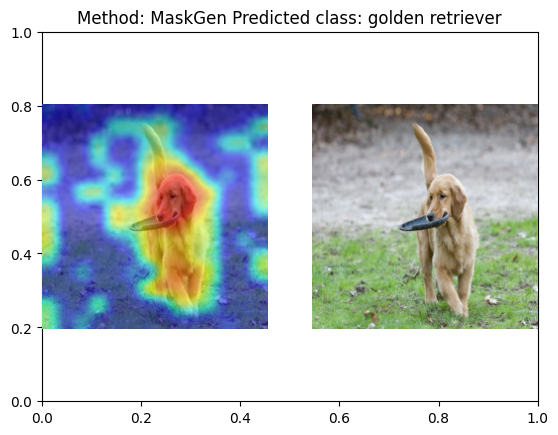

In [21]:
from maskgen.utils.img_utils import plot_overlap_np
from maskgen.utils import idx_to_selector

# url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
# url = "http://farm3.staticflickr.com/2066/1798910782_5536af8767_z.jpg"
# url = "http://farm1.staticflickr.com/184/399924547_98e6cef97a_z.jpg"
url = "http://farm1.staticflickr.com/128/318959350_1a39aae18c_z.jpg"
image = Image.open(requests.get(url, stream=True).raw)

with torch.no_grad():
    inputs = processor(images=image, return_tensors="pt")
    inputs.to(device)
    img = inputs['pixel_values']
    img = img.to(device)
    pred_class = pred_model(img).logits.argmax(-1)
    predicted_class_idx = pred_class.item()

plt.title(f"Method: MaskGen Predicted class: {pred_model.config.id2label[predicted_class_idx]}")
size = 14
N = inputs['pixel_values'].shape[0]

sim = mask_gen_model.forward(pixel_values=inputs['pixel_values'])
# selector = idx_to_selector(pred_class, 1000).unsqueeze(1) # [N, 1, n_classes]
# sim = (sim * selector).sum(-1)
# sim = sim[:,:, predicted_class_idx]

heatmap = torch.sigmoid(sim).reshape(N, size, size)

heatmap = heatmap.squeeze(0).detach().cpu().numpy()
img = img.squeeze(0).detach().cpu().numpy().transpose(1, 2, 0)

img_int, heatmap_img = plot_overlap_np(img, heatmap, mean, std)

In [11]:
print(heatmap.min())
print(heatmap.max())
print(heatmap.mean())

0.05435582
0.57342005
0.26513466


In [23]:
# save model to trained folder
import os
from datetime import datetime
state_dict = mask_gen_model.state_dict()
model_name = "vision_mask_gen_lora_" + datetime.now().strftime("%Y%m%d-%H%M%S") + ".pt"
model_path = os.path.join("trained", model_name)
torch.save(state_dict, model_path)


In [24]:
# how to check the size of the model in MB
import os
print(f"Model size: {os.path.getsize(model_path) / 1e6:.2f} MB")

Model size: 348.44 MB
